In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import plotly.express as px
import plotly.graph_objects as go
warnings.filterwarnings(action = 'ignore')
sb.set_style('darkgrid')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import Lasso,LinearRegression,ElasticNet,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,cross_val_predict
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import optuna
import pickle

In [2]:
data = pd.read_csv('../input/car-price-prediction/CarPrice_Assignment.csv')

In [3]:
data

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


In [4]:
data.drop(['car_ID','symboling'],1,inplace = True)

In [5]:
data[['Company','Model']] = data.pop('CarName').str.split(' ',n=1, expand=True)

In [6]:
df = data[['Company', 'Model','fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel',
       'enginelocation', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price']]
df

,Company,Model,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,alfa-romero,giulia,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,alfa-romero,stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,alfa-romero,Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,audi,100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,audi,100ls,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,volvo,145e (sw),gas,std,four,sedan,rwd,front,109.1,188.8,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,volvo,144ea,gas,turbo,four,sedan,rwd,front,109.1,188.8,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,volvo,244dl,gas,std,four,sedan,rwd,front,109.1,188.8,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,volvo,246,diesel,turbo,four,sedan,rwd,front,109.1,188.8,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


In [7]:
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Company,205,28,toyota,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Model,203,141,corolla,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fueltype,205,2,gas,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aspiration,205,2,std,168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
doornumber,205,2,four,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
carbody,205,5,sedan,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
drivewheel,205,3,fwd,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
enginelocation,205,2,front,202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wheelbase,205.0,NaN,NaN,NaN,98.756585,6.021776,86.6,94.5,97.0,102.4,120.9
carlength,205.0,NaN,NaN,NaN,174.049268,12.337289,141.1,166.3,173.2,183.1,208.1


In [8]:
# Function for grouping and displaying
def generate_group(column_name,kind):
    group = df[[column_name,'price']]
    group = group.groupby([column_name]).mean()
    if kind == 'bar':
        fig = px.bar(group,title = f"<b>Average Price By {column_name}</b>")
        fig.show()
    if kind == 'line':
        fig = px.line(group,title = f"<b>Average Price By {column_name}</b>")
        fig.show()
    if kind == 'scatter':
        fig = px.scatter(group,title = f"<b>Average Price By {column_name}</b>")
        fig.show()
    return group
    

In [9]:
Manufacturer_Details = generate_group('Company',kind = 'bar')

In [10]:
model_details = generate_group('Model',kind = 'bar')

In [11]:
fuel_details = generate_group('fueltype',kind = 'bar')

* <b> Diesel Cars are more expensive than gas cars

In [12]:
Aspiration_details = generate_group('aspiration',kind = 'bar')

* Turbos are more expensive than std aspirations

In [13]:
door_details = generate_group('doornumber',kind = 'bar')

* Four door cars are slightly more expensive

In [14]:
body_details = generate_group('carbody',kind = 'bar')

* Hard Tops and convertibles have the highest average price
* Hatchbacks and wagons are cheap

In [15]:
drivewheel_details = generate_group('drivewheel',kind = 'bar')

* Rwd has the higest average price

In [16]:
engine_location_details = generate_group('enginelocation',kind = 'bar')

* Rear Engine Mounted Cares are More Expensive

In [17]:
WheelBase_details = generate_group('wheelbase',kind = 'scatter')

* As wheelbase increases price tends to increase

In [18]:
car_length = generate_group('carlength',kind = 'scatter')

* As car length increases average car price tends to increase

In [19]:
car_width = generate_group('carwidth',kind = 'scatter')

* As car width increases price tends to increase

<h2> Average Price by car height</h2>

In [20]:
height_details = generate_group('carheight',kind = 'scatter')

* As it is hard to asses whether car price increases or decreases due to change in height from the above fig we make a regression plot to better understand the relation

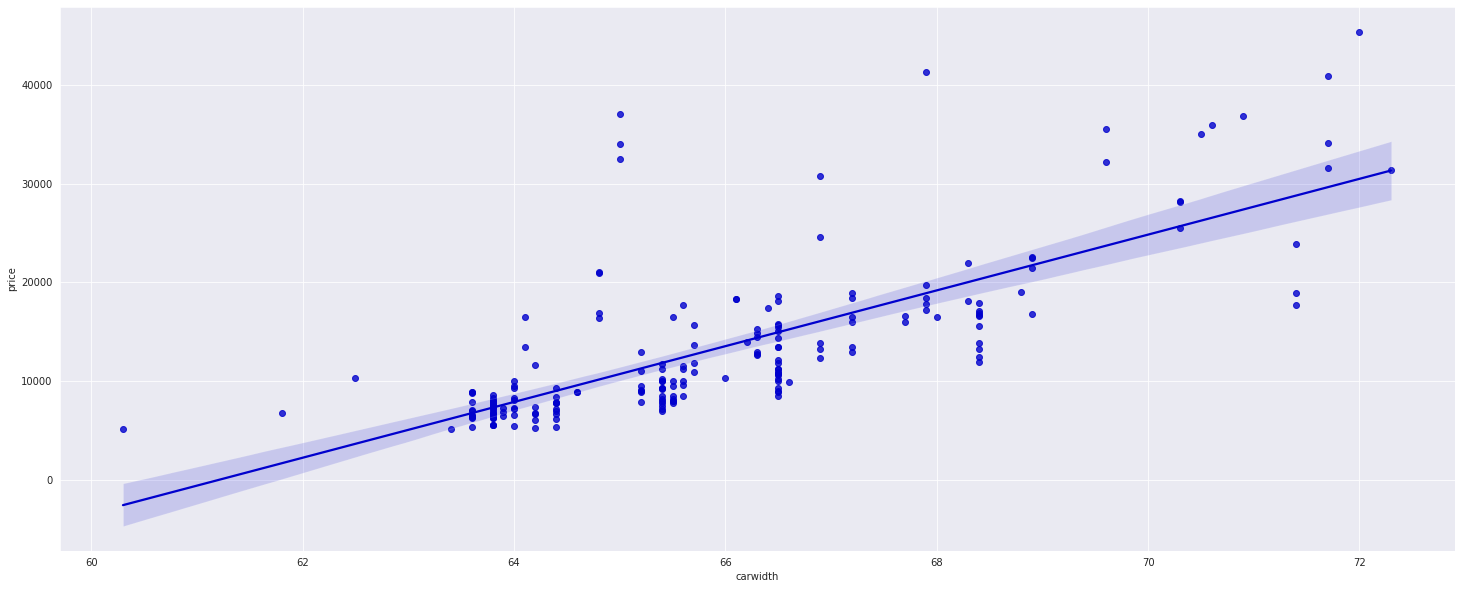

In [21]:
plt.figure(figsize = (25,10))
sb.regplot(df['carwidth'],df['price'],color = 'mediumblue');

* As car width increases price tends to increase

<h2> Average price by curbweight </h2>

In [22]:
curb_weight_details = generate_group('curbweight',kind = 'scatter')

* As curbweight increases price tends to increase

<h2> Average Price by Engine Type </h2>

In [23]:
enginetype_details  = generate_group('enginetype',kind = 'bar')

*  Dual Overhead Camshaf dohcv type of engine has the highest average price
* ohcv engine type has the next highest average price

<h2> Average Price by number of cylinders </h2>

In [24]:
cylinder_details = generate_group('cylindernumber',kind = 'bar')

* Cars with 8 cylinder engines have the highest average price followed by 12,6,5,2,4,3 cylinder engines

<h2> Average Price by engine size </h2>

In [25]:
engine_size_details = generate_group('enginesize',kind = 'scatter')

* As engine size increases car price also increases

<h2> Average Price bt fuel system</h2>

In [26]:
fuel_syst_details = generate_group('fuelsystem',kind = 'bar')

* cars with mpfi fuel system has the highest average price followed by idi
* 1bbl and 2bbl fuel system have the lowesr average price

<h2> Average Price by boreratio </h2>

In [27]:
bore_details = generate_group('boreratio',kind = 'scatter')

* As Bore Ratio Increases Price Increases

<h2> Average price by stroke </h2>

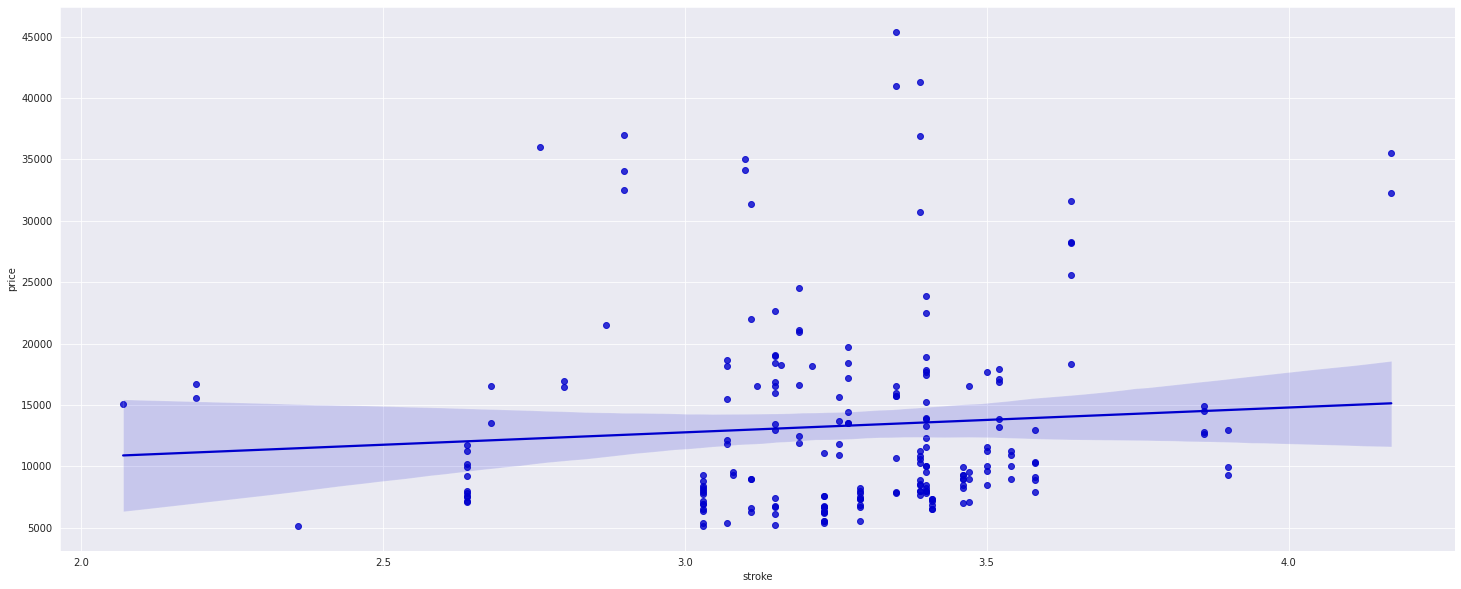

In [28]:
plt.figure(figsize = (25,10))
sb.regplot(df['stroke'],df['price'],color = 'mediumblue');

* As stroke increases car price tends to increase

<h2> Average Price by Compression Ratio </h2>

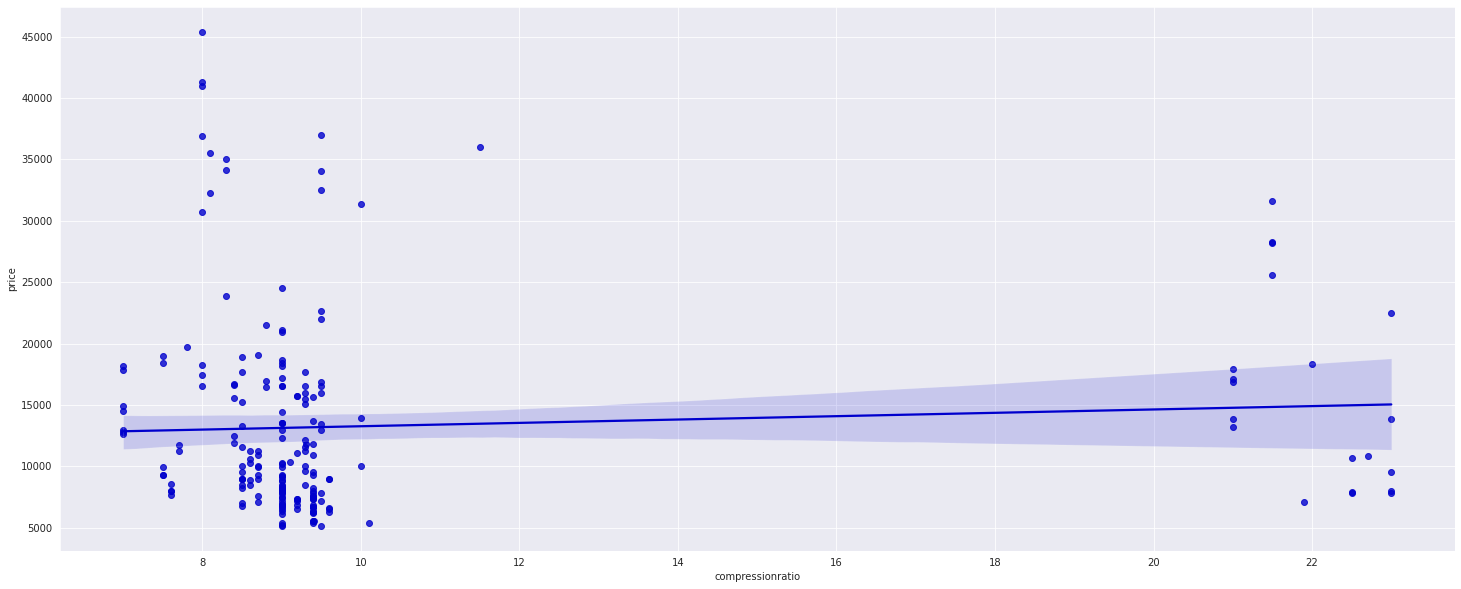

In [29]:
plt.figure(figsize = (25,10))
sb.regplot(df['compressionratio'],df['price'],color = 'mediumblue');

* As compression Ratio incrases price increases slightly

<h2> Average Price by Horsepower</h2>

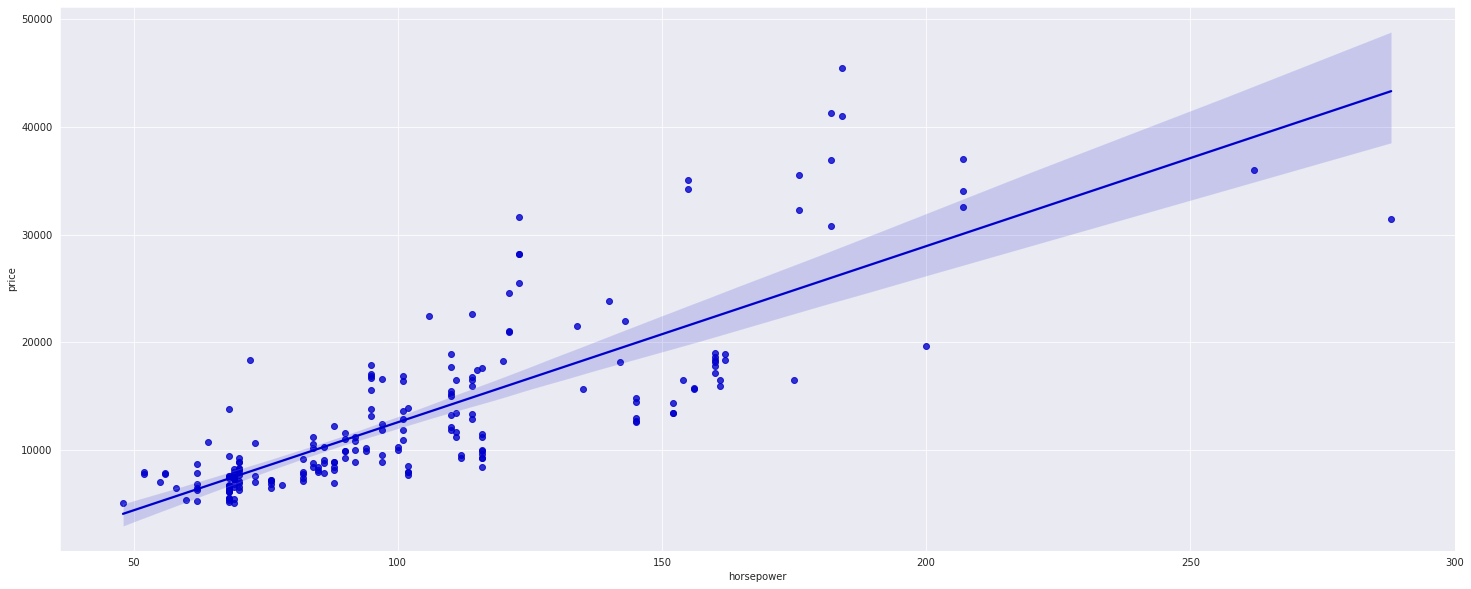

In [30]:
plt.figure(figsize = (25,10))
sb.regplot(df['horsepower'],df['price'],color = 'mediumblue');

* As HorsePower Increases price increases

<h2> Average price by peak rpm

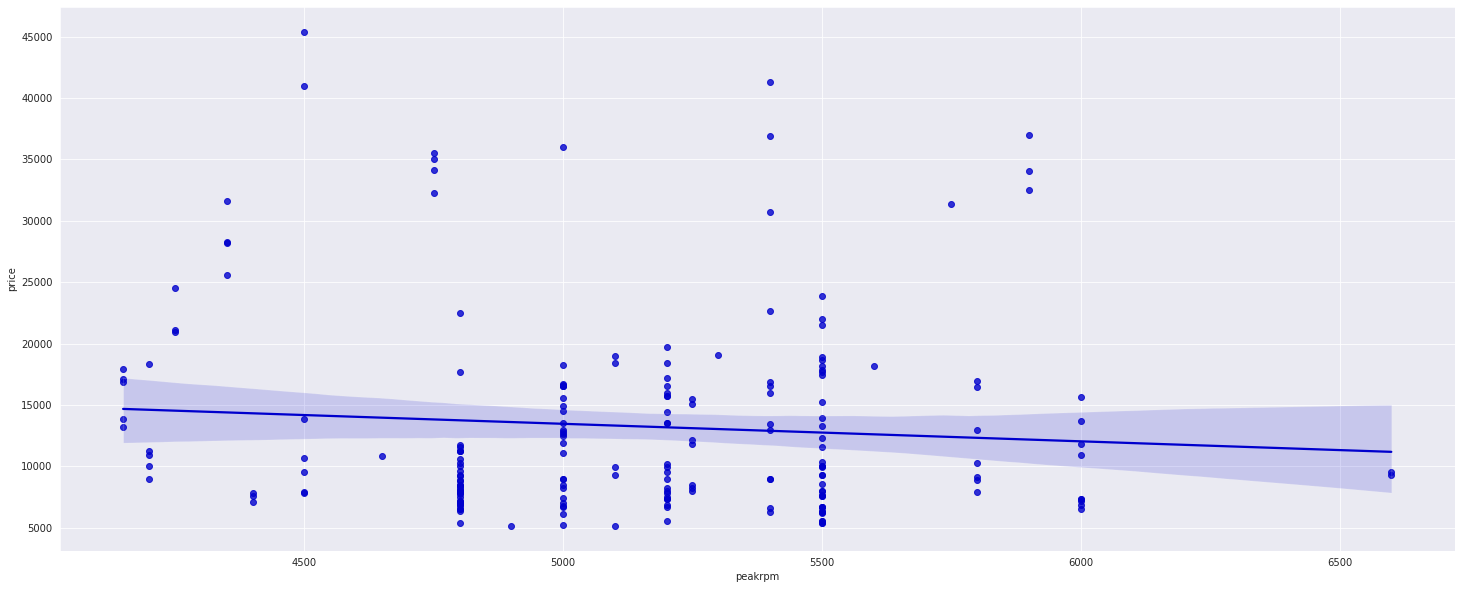

In [31]:
plt.figure(figsize = (25,10))
sb.regplot(df['peakrpm'],df['price'],color = 'mediumblue');

* price decreases as peak rpm incrases

<h2> Average price by city mileage </h2>

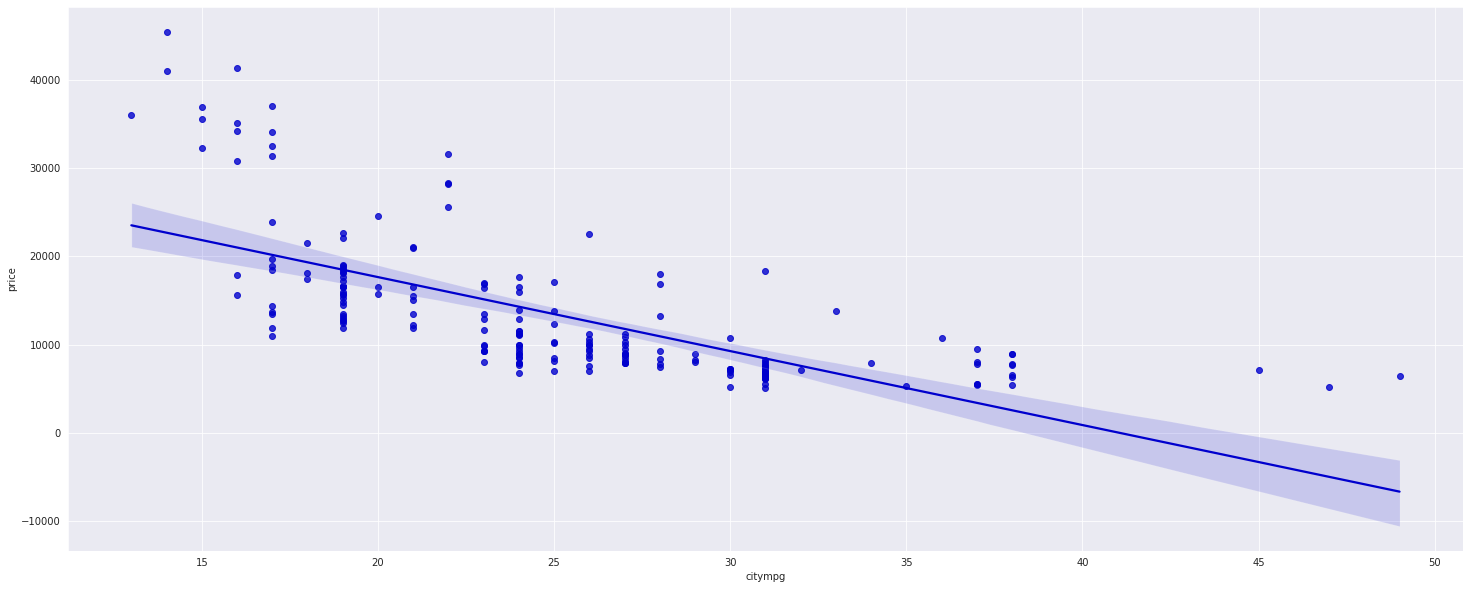

In [32]:
plt.figure(figsize = (25,10))
sb.regplot(df['citympg'],df['price'],color = 'mediumblue');

* As city mileage increases price decreases

<h2> Average price by highway mileage </h2>

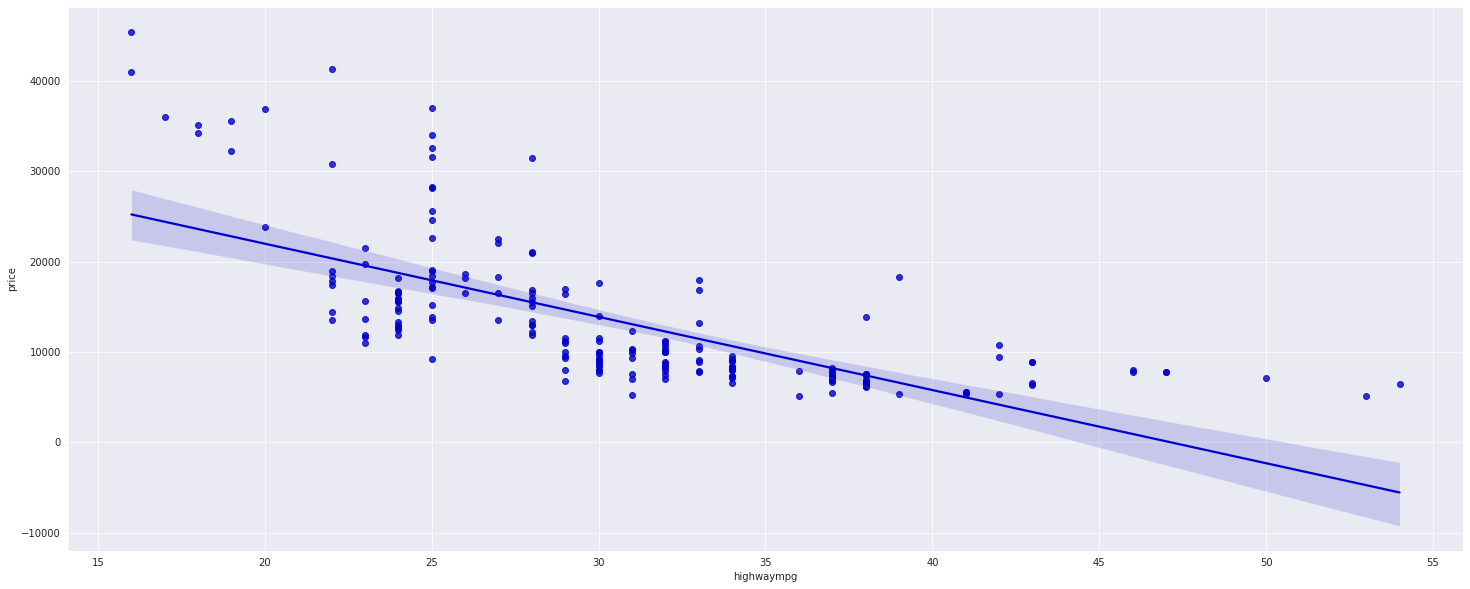

In [33]:
plt.figure(figsize = (25,10))
sb.regplot(df['highwaympg'],df['price'],color = 'mediumblue');

* As highway mileage increases price decreases

In [34]:
le = LabelEncoder()
df['Company'] = le.fit_transform(df['Company'])
df['Model'] = le.fit_transform(df['Model'])

In [35]:
def preprocessing(data,target):
    processed_data = convert_categorical_to_numbers(data)
    processed_data = auto_data_impute(data)
    #processed_data = scaling_data(data,target)
    print("Pre-Processing done")
    return processed_data


def convert_categorical_to_numbers(data,unique_val=10):
    """converts categorical object dtypes to numeric encoded format"""
    obj_df = data.select_dtypes(include=[object])
    unique_list = [f for f in obj_df.columns if obj_df[f].unique().shape[0]>=unique_val]
    obj_df_sel = obj_df.drop(columns=unique_list)
    for col in obj_df_sel.columns:
        data[col] = pd.factorize(data[col])[0]
    print("conversion successfull")
    return data

def auto_data_impute(data,get_rid_percent=2):
    for x,y in data.isnull().sum().items():
        percent = y/data.shape[0]
        if percent <= get_rid_percent/100:
            data[x]  = data[x].fillna(data[x].mean())
        else:
            print("removed column : ",x)
            data = data.drop([x],axis=1)
    print("Data imputation successfull")
    return data

def scaling_data(data,target):
    num_df = data.select_dtypes(include = [int,float])
    for i in num_df:
        if i!=target:
            data[i] = data[i]/data[i].max()
    print("scaling was successfull")
    return data

In [36]:
data = preprocessing(df,'price')

conversion successfull
Data imputation successfull
Pre-Processing done


In [37]:
data

,Company,Model,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,78,0,0,0,0,0,0,88.6,168.8,...,130,0,3.47,2.68,9.0,111,5000,21,27,13495.0
1,1,122,0,0,0,0,0,0,88.6,168.8,...,130,0,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,28,0,0,0,1,0,0,94.5,171.2,...,152,0,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,0,0,0,1,2,1,0,99.8,176.6,...,109,0,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,1,0,0,1,2,2,0,99.4,176.6,...,136,0,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,26,5,0,0,1,2,0,0,109.1,188.8,...,141,0,3.78,3.15,9.5,114,5400,23,28,16845.0
201,26,4,0,1,1,2,0,0,109.1,188.8,...,141,0,3.78,3.15,8.7,160,5300,19,25,19045.0
202,26,6,0,0,1,2,0,0,109.1,188.8,...,173,0,3.58,2.87,8.8,134,5500,18,23,21485.0
203,26,8,1,1,1,2,0,0,109.1,188.8,...,145,6,3.01,3.40,23.0,106,4800,26,27,22470.0


# Analysis of data for Machine Learning and Required Preprocessing

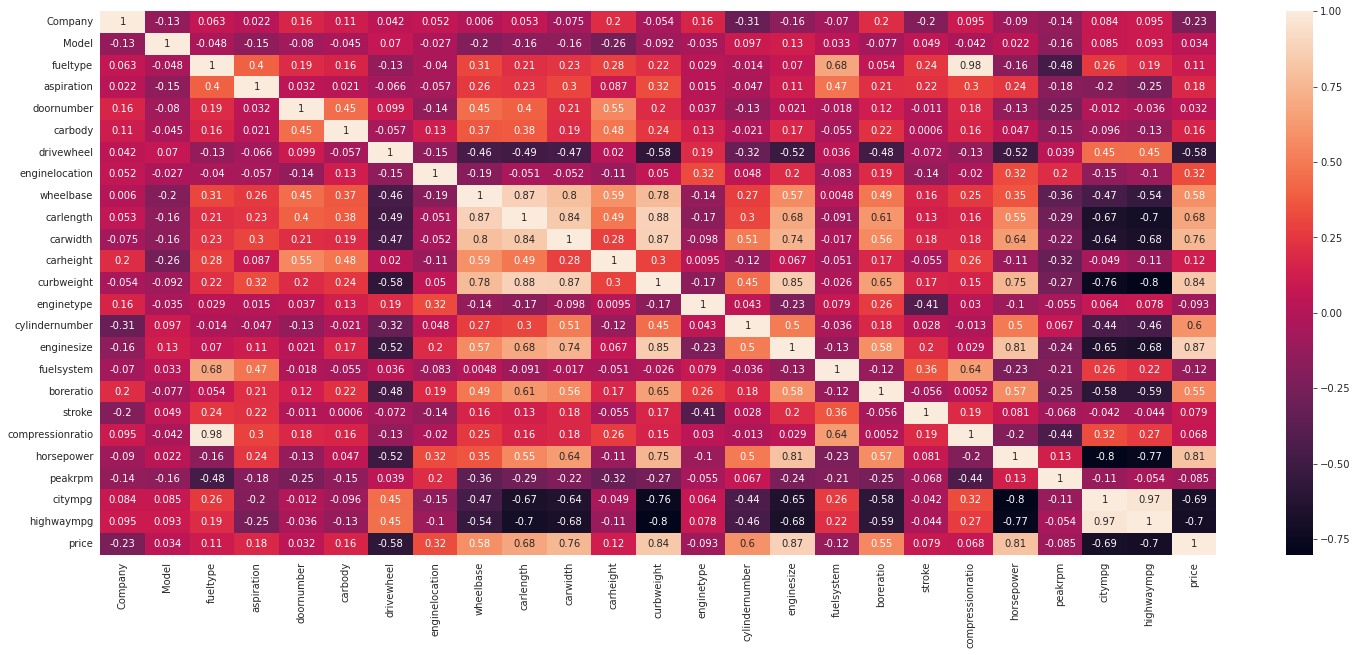

In [38]:
plt.figure(figsize = (25,10))
sb.heatmap(data.corr(),annot = True);

In [39]:
x = data.iloc[:,:24]
y = data['price']

In [40]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.24,random_state = 1)

# Feature Selection

In [41]:
def objective(trial):
    alpha = trial.suggest_uniform('alpha',0.0,2.0)
    x,y,_ = get_data(data,'price')
    lasso_model = Lasso(alpha=alpha)
    acc = cross_val_score(lasso_model,x , y,scoring='r2',cv=5).mean()
    acc = -acc
    return acc

def feature_selection(data,target,objective,n_trials=20):
    x,y,cols = get_data(data,target)
    study = optuna.create_study(direction='minimize')
    study.optimize(objective,n_trials=50)
    lasso_model = Lasso(**study.best_params)
    lasso_model.fit(x,y)
    coeff = np.abs(lasso_model.coef_)
    feats = np.array(x.columns)[coeff>0].tolist()
    feats = feats+['price']
    return feats

def get_data(data,target):
    x,y = data.drop(labels=[target],axis=1),data[target]
    cols = x.columns
    return x,y,cols
features = feature_selection(data,'price',objective)

[I 2022-06-24 06:33:56,212] A new study created in memory with name: no-name-4e0085f3-d2d7-4eec-866d-a7a6dff96fdc
[I 2022-06-24 06:33:56,264] Trial 0 finished with value: -0.5962864235268249 and parameters: {'alpha': 0.1368533707601023}. Best is trial 0 with value: -0.5962864235268249.
[I 2022-06-24 06:33:56,312] Trial 1 finished with value: -0.5994129382202458 and parameters: {'alpha': 0.8407163694523496}. Best is trial 1 with value: -0.5994129382202458.
[I 2022-06-24 06:33:56,368] Trial 2 finished with value: -0.5957963106089387 and parameters: {'alpha': 0.033462906892095745}. Best is trial 1 with value: -0.5994129382202458.
[I 2022-06-24 06:33:56,414] Trial 3 finished with value: -0.6023037245496015 and parameters: {'alpha': 1.516313674177413}. Best is trial 3 with value: -0.6023037245496015.
[I 2022-06-24 06:33:56,457] Trial 4 finished with value: -0.6020106147361639 and parameters: {'alpha': 1.4464348244927683}. Best is trial 3 with value: -0.6023037245496015.
[I 2022-06-24 06:33:

In [42]:
data[features]

,Company,Model,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,78,0,0,0,0,0,0,88.6,168.8,...,130,0,3.47,2.68,9.0,111,5000,21,27,13495.0
1,1,122,0,0,0,0,0,0,88.6,168.8,...,130,0,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,28,0,0,0,1,0,0,94.5,171.2,...,152,0,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,0,0,0,1,2,1,0,99.8,176.6,...,109,0,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,1,0,0,1,2,2,0,99.4,176.6,...,136,0,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,26,5,0,0,1,2,0,0,109.1,188.8,...,141,0,3.78,3.15,9.5,114,5400,23,28,16845.0
201,26,4,0,1,1,2,0,0,109.1,188.8,...,141,0,3.78,3.15,8.7,160,5300,19,25,19045.0
202,26,6,0,0,1,2,0,0,109.1,188.8,...,173,0,3.58,2.87,8.8,134,5500,18,23,21485.0
203,26,8,1,1,1,2,0,0,109.1,188.8,...,145,6,3.01,3.40,23.0,106,4800,26,27,22470.0


# Model Selection

In [43]:
# Function for evaluating model performance
def model_performance(model,model_name,x_train = x_train,y_train = y_train,x_test = x_test,y_test = y_test):
    
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    Training_Score = np.round(model.score(x_train,y_train),3)
    Testing_Score = np.round(model.score(x_test,y_test),3)
    
    mse_training = np.round(mean_squared_error(y_train,y_train_pred),3)
    mse_testing = np.round(mean_squared_error(y_test,y_test_pred),3)
    
    mae_training = np.round(mean_absolute_error(y_train,y_train_pred),3)
    mae_testing = np.round(mean_absolute_error(y_test,y_test_pred),3)
    
    r2_training = np.round(r2_score(y_train,y_train_pred),3)
    r2_testing = np.round(r2_score(y_test,y_test_pred),3)
    
    
    print("Model Performance for:",model_name)
    print("")
    
    print("Training Score:",Training_Score)
    print("Testing Score:",Testing_Score)
    print("")
    
    print("Training Data Mean Squared Error:",mse_training)
    print("Testing Data Mean Squared Error:",mse_testing)
    print("")
    
    print("Training Data Mean Absolute Error:",mae_training)
    print("Testing Data Mean Absolute Error:",mae_testing)
    print("")
    
    print("Training Data r2_score:",r2_training)
    print("Testing Data r2_score:",r2_testing)
    print("")
    
    print("Residual Analysis:")
    plt.figure(figsize = (20,5))
    plt.scatter(y_train,(y_train-y_train_pred),color = "red",label = 'Training Predictions')
    plt.scatter(y_test,(y_test-y_test_pred),color = "green",label = 'Testing Predictions')
    plt.legend()
    plt.show()
    
    return Training_Score,Testing_Score,mse_training,mse_testing,mae_training,mae_testing,r2_training,r2_testing

In [44]:
model1 = LinearRegression()
model1.fit(x_train,y_train)

LinearRegression()

Model Performance for: LinearRegression()

Training Score: 0.923
Testing Score: 0.854

Training Data Mean Squared Error: 4826356.858
Testing Data Mean Squared Error: 9469387.076

Training Data Mean Absolute Error: 1672.527
Testing Data Mean Absolute Error: 1910.118

Training Data r2_score: 0.923
Testing Data r2_score: 0.854

Residual Analysis:


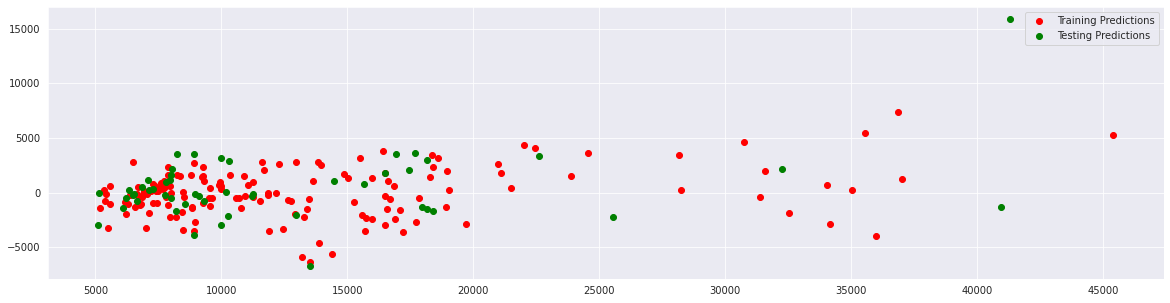

In [45]:
Linear_regression_performance = model_performance(model1,model_name = model1)